In [1]:
!pip install kagglehub pandas matplotlib numpy pillow tensorflow seaborn scikit-learn

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ishanikathuria/handwritten-signature-datasets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/handwritten-signature-datasets


# Training model

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random

def setup_device():
    """Настраивает устройство для обучения (GPU/CPU)"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            device = '/GPU:0'
            print(f"Используется GPU: {gpus[0].name}")
        except RuntimeError as e:
            print(e)
            device = '/CPU:0'
            print("Используется CPU")
    else:
        device = '/CPU:0'
        print("GPU не найден, используется CPU")
    
    return device

def load_dataset_from_folder(folder, target_size=(128, 128)):
    """
    Loads a dataset and organizes it into classes for a triplet network
    """
    genuine_images = []
    forged_images = []
    
    print("Loading data for a triplet network")
    
    for root, dirs, files in os.walk(folder):
        for filename in files:
            file_path = os.path.join(root, filename)
            
            # Uploading and processing the image
            img = Image.open(file_path).convert('L')
            img = img.resize(target_size)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=-1)  # (128, 128, 1)
            
            if '-G-' in filename.upper():
                genuine_images.append(img_array)
            elif '-F-' in filename.upper():
                forged_images.append(img_array)
                    
    print(f"Real signatures (G): {len(genuine_images)}")
    print(f"Fake signatures (F): {len(forged_images)}")
    
    return genuine_images, forged_images

def build_embedding_network(input_shape=(128, 128, 1)):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation=None, name='embedding_output')
    ])
    return model

class TripletLossLayer(layers.Layer):
    """Custom layer for triplet loss"""
    def __init__(self, alpha=0.2, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + self.alpha
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
        return loss
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_triplet_model(input_shape=(128, 128, 1)):
    """Builds a full triplet network with a custom loss layer"""
    # Basic network for feature extraction
    embedding_network = build_embedding_network(input_shape)
    
    # Triplet inputs
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')
    
    # Embeddings for each input (shared weights)
    anchor_embedding = embedding_network(anchor_input)
    positive_embedding = embedding_network(positive_input)
    negative_embedding = embedding_network(negative_input)
    
    # loss layer
    loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss')(
        [anchor_embedding, positive_embedding, negative_embedding]
    )
    
    # Three-input model
    triplet_model = Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=loss_layer
    )
    
    return triplet_model, embedding_network

def create_triplet_dataset(genuine_images, forged_images, batch_size=32):
    """Creates a tf.data.Dataset for triplet training"""
    def triplet_generator():
        while True:
            batch_anchors = []
            batch_positives = []
            batch_negatives = []
            
            for _ in range(batch_size):
                # With a 50% probability, we choose a real or fake signature as an anchor
                if random.random() < 0.5 and len(genuine_images) > 1:
                    # Anchor
                    anchor_idx = random.randint(0, len(genuine_images) - 1)
                    anchor = genuine_images[anchor_idx]
                    
                    # Positive
                    positive_idx = random.randint(0, len(genuine_images) - 1)
                    while positive_idx == anchor_idx:
                        positive_idx = random.randint(0, len(genuine_images) - 1)
                    positive = genuine_images[positive_idx]
                    
                    # Negative
                    negative_idx = random.randint(0, len(forged_images) - 1)
                    negative = forged_images[negative_idx]
                    
                else:
                    # Anchor
                    anchor_idx = random.randint(0, len(forged_images) - 1)
                    anchor = forged_images[anchor_idx]
                    
                    # Positive
                    positive_idx = random.randint(0, len(forged_images) - 1)
                    while positive_idx == anchor_idx:
                        positive_idx = random.randint(0, len(forged_images) - 1)
                    positive = forged_images[positive_idx]
                    
                    # Negative
                    negative_idx = random.randint(0, len(genuine_images) - 1)
                    negative = genuine_images[negative_idx]
                
                batch_anchors.append(anchor)
                batch_positives.append(positive)
                batch_negatives.append(negative)
            
            # to np array
            batch_anchors = np.array(batch_anchors)
            batch_positives = np.array(batch_positives)
            batch_negatives = np.array(batch_negatives)
            
            inputs = {
                'anchor_input': batch_anchors,
                'positive_input': batch_positives,
                'negative_input': batch_negatives
            }
            
            # Empty outputs (loss is calculated inside the model)


            dummy_outputs = np.zeros((batch_size, 1))
            
            yield inputs, dummy_outputs
    
    # Defining output_signature for tf.data.Dataset
    output_signature = (
        {
            'anchor_input': tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
            'positive_input': tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
            'negative_input': tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
    
    dataset = tf.data.Dataset.from_generator(
        triplet_generator,
        output_signature=output_signature
    )
    
    return dataset

def create_classifier(embedding_network, input_shape=(128, 128, 1)):
    """Creates a classifier based on a trained embedding network"""
    # Create a new model with the same embedding layer.
    input_layer = layers.Input(shape=input_shape)
    embedding = embedding_network(input_layer)
    
    # Adding classification layers
    x = layers.Dense(64, activation='relu')(embedding)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid', name='classification_output')(x)
    
    classifier = Model(inputs=input_layer, outputs=output)
    
    return classifier

def plot_training_history(history):
    """Vizualizing learning TNN"""
    plt.figure(figsize=(10, 5))
    
    # График потерь
    plt.plot(history.history['loss'], label='Triplet Loss', linewidth=2)
    plt.title('Triplet Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('triplet_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_classifier_history(history):
    """Vizualizing learning classifier"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # График точности
    ax1.plot(history.history['accuracy'], label='Обучающая точность', linewidth=2)
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Валидационная точность', linewidth=2)
    ax1.set_title('Точность модели', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # loss
    ax2.plot(history.history['loss'], label='Обучающие потери', linewidth=2)
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Валидационные потери', linewidth=2)
    ax2.set_title('Потери модели', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Потери')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # precision
    if 'precision' in history.history:
        ax3.plot(history.history['precision'], label='Обучающая precision', linewidth=2)
        if 'val_precision' in history.history:
            ax3.plot(history.history['val_precision'], label='Валидационная precision', linewidth=2)
        ax3.set_title('Precision', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Эпоха')
        ax3.set_ylabel('Precision')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # recall
    if 'recall' in history.history:
        ax4.plot(history.history['recall'], label='Обучающий recall', linewidth=2)
        if 'val_recall' in history.history:
            ax4.plot(history.history['val_recall'], label='Валидационный recall', linewidth=2)
        ax4.set_title('Recall', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Эпоха')
        ax4.set_ylabel('Recall')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('classifier_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    device = setup_device()
    
    TARGET_SIZE = (128, 128)
    BATCH_SIZE = 32
    EPOCHS = 100
    
    print("=" * 60)
    print("DATA LOADING FOR A TRIPLE NETWORK")
    print("=" * 60)
    
    genuine_imgs, forged_imgs = load_dataset_from_folder(
        "/kaggle/input/handwritten-signature-datasets/BHSig260-Bengali/BHSig260-Bengali", 
        target_size=TARGET_SIZE
    )
    
    # Разделение на train/validation
    split_idx = int(0.8 * len(genuine_imgs))
    genuine_train = genuine_imgs[:split_idx]
    genuine_val = genuine_imgs[split_idx:]
    
    split_idx = int(0.8 * len(forged_imgs))
    forged_train = forged_imgs[:split_idx]
    forged_val = forged_imgs[split_idx:]
    
    print(f"Training sample:")
    print(f"  - Reals: {len(genuine_train)}, Fakes: {len(forged_train)}")
    print(f"Val sample:")
    print(f"  - Reals: {len(genuine_val)}, Fakes: {len(forged_val)}")
    
    # Создаем tf.data.Dataset для обучения
    train_dataset = create_triplet_dataset(genuine_train, forged_train, BATCH_SIZE)
    
    # Построение триплетной модели
    print("CONSTRUCTION OF A TRIPLET MODEL")
    
    with tf.device(device):
        triplet_model, embedding_network = build_triplet_model(input_shape=(128, 128, 1))
        
        # Model compilation (without external loss function)
        triplet_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
            # We do not specify loss, since it is calculated inside the model.
        )
    
    print("Triplet model architecture:")
    triplet_model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            patience=15, 
            restore_best_weights=True, 
            verbose=1,
            monitor='loss'
        ),
        ReduceLROnPlateau(
            patience=8, 
            factor=0.5, 
            verbose=1,
            monitor='loss'
        ),
        ModelCheckpoint(
            'best_triplet_model.h5', 
            save_best_only=True, 
            verbose=1,
            monitor='loss'
        )
    ]
    
    # TNN learning
    print("TNN learning")
    
    steps_per_epoch = min(len(genuine_train), len(forged_train)) // BATCH_SIZE
    
    with tf.device(device):
        history = triplet_model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
    
    # train vizulizing
    plot_training_history(history)
    
    # Creating and training a classifier based on embeddings
    print("CREATING A CLASSIFIER")
    
    # Preparing data for the classifier
    X_train = np.array(genuine_train + forged_train)
    y_train = np.array([1] * len(genuine_train) + [0] * len(forged_train))
    
    X_val = np.array(genuine_val + forged_val)
    y_val = np.array([1] * len(genuine_val) + [0] * len(forged_val))
    
    # Shuffle the data
    train_indices = np.random.permutation(len(X_train))
    val_indices = np.random.permutation(len(X_val))
    
    X_train = X_train[train_indices]
    y_train = y_train[train_indices]
    X_val = X_val[val_indices]
    y_val = y_val[val_indices]
    
    # making a classifier
    with tf.device(device):
        classifier = create_classifier(embedding_network)
        
        # Freezing the weights of the embedding network
        embedding_network.trainable = False
        
        classifier.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
    
    # train classifier
    print("classifier training")
    
    classifier_callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
    ]
    
    with tf.device(device):
        classifier_history = classifier.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=100,
            validation_data=(X_val, y_val),
            callbacks=classifier_callbacks,
            verbose=1
        )
    
    # viz
    plot_classifier_history(classifier_history)
    
    # Model evaluation
    print("Model evaluation")
    
    val_loss, val_accuracy, val_precision, val_recall = classifier.evaluate(X_val, y_val, verbose=0)
    print(f"accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    
    # Predictions for a detailed report
    y_pred = (classifier.predict(X_val, verbose=0) > 0.5).astype(int).flatten()
    
    print("\nError Matrix:")
    cm = confusion_matrix(y_val, y_pred)
    print(cm)
    
    print("\nDetailed classification report:")
    print(classification_report(y_val, y_pred, target_names=['fake', 'real']))
    
    # saving models
    print("\nSaving Models")
    embedding_network.save('signature_embedding_network.h5')
    classifier.save('signature_classifier.h5')
    print("Models saved")
    
    print("\n" + "=" * 60)
    print("Training is over")
    print("=" * 60)
    print(f"Final accuracy of the classifier: {val_accuracy:.4f}")

if __name__ == "__main__":
    main()

# Lets make some predicts

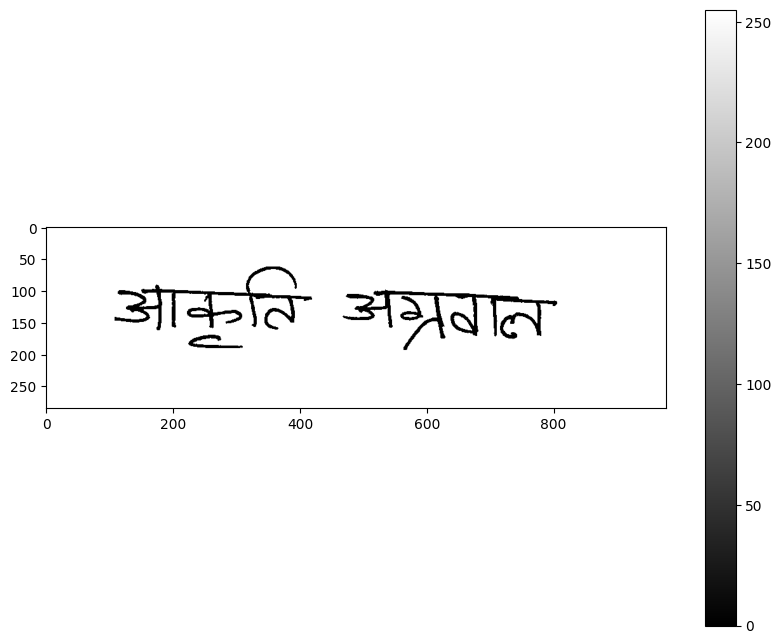

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image = Image.open('/kaggle/input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-01.tif')

image_array = np.array(image)

# Отображаем изображение
plt.figure(figsize=(10, 8))
plt.imshow(image_array, cmap='gray')
plt.colorbar()
plt.show()

In [23]:
def predict_signature(image_path, embedding_network_path='signature_embedding_network.h5', 
                     classifier_path='signature_classifier.h5', target_size=(128, 128)):

    # load models
    embedding_network = tf.keras.models.load_model(embedding_network_path, compile=False)
    classifier = tf.keras.models.load_model(classifier_path, compile=False)
    
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))  # (1, 128, 128, 1)
    
    # Getting embeddings
    embedding = embedding_network.predict(img_array, verbose=0)
    
    # Classify
    prediction = classifier.predict(img_array, verbose=0)[0][0]
    
    if prediction > 0.5:
        result = "REAL"
        confidence = prediction
    else:
        result = "FAKE"
        confidence = 1 - prediction
    
    print(f"result: {result}")
    print(f"confidence: {confidence:.4f}")
    
    return result, confidence, prediction, embedding

result, confidence, prob, embedding = predict_signature("/kaggle/input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-01.tif")  # FAKE IMG
result, confidence, prob, embedding = predict_signature("/kaggle/input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-01.tif")  # REAL IMG

result: FAKE
confidence: 0.6660
result: REAL
confidence: 0.5599
